## **QnA Bot Menggunakan Pre-Trained Model BERT**

In [ ]:
!pip install transformers datasets evaluate accelerate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00


Import dataset berupa SQuAD.

In [ ]:
from datasets import load_dataset

data = load_dataset(
    'json',
    data_files={
        'train': '/content/train-SQuAD-id.json'
    }
)

print(data)


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['version', 'data'],
        num_rows: 1
    })
})


Pre-processing Dataset (Flatten Format SQuAD) (Context, Question, Answer)

In [ ]:
import json

def extract_squad_format(dataset):
    contexts, questions, answers = [], [], []
    for article in dataset['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                if len(qa['answers']) > 0:
                    answer = qa['answers'][0]
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    return {'context': contexts, 'question': questions, 'answers': answers}


train_data = extract_squad_format(json.load(open('/content/train-SQuAD-id.json')))

len(train_data['context']), len(train_data['question'])


print("Jumlah data:", len(contexts))
print("Contoh context:", contexts[0][:100])
print("Contoh question:", questions[0])
print("Contoh answer:", answers[0])


Jumlah data: 76444
Contoh context: Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ / bee-YON-say) (lahir 4 September 1981) adalah seorang 
Contoh question: Kapan Beyonce mulai populer?
Contoh answer: {'text': 'pada akhir 1990-an', 'answer_start': 299}


**Tokenisasi Dataset**

Menggunakan tokenizer dari BERT multilingual agar mendukung Bahasa Indonesia

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)
        answer['end'] = end_idx

add_end_idx(train_data['answers'], train_data['context'])

def preprocess_function(examples):
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length"
    )

    start_positions = []
    end_positions = []

    for i, offset in enumerate(inputs["offset_mapping"]):
        start_char = examples["answers"][i]["answer_start"]
        end_char = examples["answers"][i]["end"]
        sequence_ids = inputs.sequence_ids(i)

        # Temukan token yang sesuai dengan jawaban
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs.pop("offset_mapping")
    return inputs


Pembuatan Dataset untuk train (Finetune model)

In [ ]:
from datasets import Dataset

dataset_train = Dataset.from_dict(train_data)
tokenized_train = dataset_train.map(preprocess_function, batched=True, remove_columns=dataset_train.column_names)


Map:   0%|          | 0/76444 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

args = TrainingArguments(
    "bert-finetuned-squad-id",
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train
)

trainer.train()


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muhfahrezafauzan16 (muhfahrezafauzan16-indonesia-university-of-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,2.555700
1000,2.045700
1500,1.926200
2000,1.883000
2500,1.797400
3000,1.790300
3500,1.704400
4000,1.756800
4500,1.708000
5000,1.641800


TrainOutput(global_step=19112, training_loss=1.4626300463670465, metrics={'train_runtime': 3863.3058, 'train_samples_per_second': 39.574, 'train_steps_per_second': 4.947, 'total_flos': 2.9961853907890176e+16, 'train_loss': 1.4626300463670465, 'epoch': 2.0})

Save model hasil fine tune

In [ ]:
trainer.save_model("/content/bert-squad-id")
tokenizer.save_pretrained("/content/bert-squad-id")


('/content/bert-squad-id/tokenizer_config.json',
 '/content/bert-squad-id/special_tokens_map.json',
 '/content/bert-squad-id/vocab.txt',
 '/content/bert-squad-id/added_tokens.json',
 '/content/bert-squad-id/tokenizer.json')

Pengetesan

In [ ]:
from transformers import pipeline

qa_pipeline = pipeline("question-answering", model="/content/bert-squad-id", tokenizer=tokenizer)

context = """
Beyoncé adalah seorang penyanyi, penulis lagu, dan aktris asal Amerika Serikat.
Ia dikenal sebagai salah satu artis paling berpengaruh di dunia.
"""

question = "Siapa Beyoncé?"

result = qa_pipeline(question=question, context=context)
print(result)


Device set to use cuda:0


{'score': 0.24649064242839813, 'start': 24, 'end': 80, 'answer': 'penyanyi, penulis lagu, dan aktris asal Amerika Serikat.'}


In [ ]:
context = """
Meskipun banyak orang mengira bahwa bumi itu datar di masa lalu,
bukti ilmiah menunjukkan bahwa bumi berbentuk bulat.
Satelit dan foto dari luar angkasa telah membuktikan hal ini secara nyata.
"""

question = "Apa bentuk bumi menurut bukti ilmiah?"
result = qa_pipeline(question=question, context=context)
print(result)


{'score': 0.575985332543496, 'start': 112, 'end': 117, 'answer': 'bulat'}


Test dengan konteks lebih panjang dan beberapa diluar data train Squad

In [ ]:
test_contexts = [
    {
        "context": """
        Isaac Newton adalah seorang ilmuwan Inggris yang dikenal karena kontribusinya di bidang fisika dan matematika.
        Salah satu penemuannya yang paling terkenal adalah hukum gravitasi universal, yang menjelaskan gaya tarik antara
        dua benda bermassa. Menurut legenda, ide tentang gravitasi muncul ketika Newton melihat sebuah apel jatuh dari pohon,
        yang kemudian membuatnya berpikir mengapa benda selalu jatuh ke arah tanah.
        """,
        "question": "Apa yang menginspirasi Isaac Newton menemukan hukum gravitasi?"
    },
    {
        "context": """
        Pada tahun 1998, dua mahasiswa dari Stanford University bernama Larry Page dan Sergey Brin mendirikan Google
        sebagai proyek penelitian. Tujuan awalnya adalah untuk menciptakan mesin pencari yang mampu mengindeks dan
        mengurutkan informasi di internet dengan lebih efisien. Proyek tersebut kemudian berkembang pesat dan menjadi
        salah satu perusahaan teknologi terbesar di dunia dengan berbagai produk seperti Gmail, YouTube, dan Android.
        """,
        "question": "Apa tujuan awal Larry Page dan Sergey Brin saat mendirikan Google?"
    },
    {
        "context": """
        Air merupakan senyawa kimia yang sangat penting bagi kehidupan di bumi. Setiap molekul air terdiri dari dua atom
        hidrogen dan satu atom oksigen, yang dikenal dengan rumus H₂O. Air dapat ditemukan dalam tiga wujud, yaitu padat
        (es), cair, dan gas (uap air). Selain menjadi komponen utama dalam tubuh makhluk hidup, air juga berperan penting
        dalam mengatur suhu bumi melalui proses evaporasi dan kondensasi.
        """,
        "question": "Apa rumus kimia dari air?"
    },
    {
        "context": """
        Beyoncé adalah seorang penyanyi, penulis lagu, dan produser rekaman asal Amerika Serikat.
        Ia pertama kali terkenal sebagai anggota dari grup musik Destiny's Child, sebelum kemudian sukses
        menjalani karier solo. Beyoncé dikenal karena kemampuan vokalnya yang luar biasa, pertunjukan panggung yang
        energik, dan pengaruhnya terhadap budaya pop dunia. Ia juga terlibat dalam berbagai kegiatan kemanusiaan dan
        pemberdayaan perempuan.
        """,
        "question": "Bagaimana Beyoncé pertama kali menjadi terkenal?"
    }
]

for item in test_contexts:
    result = qa_pipeline(question=item["question"], context=item["context"])
    print(f"Q: {item['question']}")
    print(f"A: {result['answer']}\n")


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Q: Apa yang menginspirasi Isaac Newton menemukan hukum gravitasi?
A: gaya tarik antara 
        dua benda bermassa.

Q: Apa tujuan awal Larry Page dan Sergey Brin saat mendirikan Google?
A: menciptakan mesin pencari

Q: Apa rumus kimia dari air?
A: H₂O

Q: Bagaimana Beyoncé pertama kali menjadi terkenal?
A: anggota dari grup musik Destiny's Child



(Percobaan) Test Generalisasi menggunakan konteks yang dapat ambigu.

In [ ]:
complex_tests = [
    {
        "context": """
        Banyak orang di masa lalu percaya bahwa bumi itu datar, dan gagasan ini bertahan selama berabad-abad karena
        kurangnya bukti ilmiah yang dapat diakses masyarakat umum. Namun, dengan berkembangnya astronomi dan navigasi,
        berbagai pengamatan mulai menunjukkan bahwa bumi berbentuk bulat. Misalnya, kapal yang berlayar jauh tampak
        perlahan menghilang dari bagian bawah ke atas di cakrawala. Selain itu, gambar dari satelit modern memperlihatkan
        secara jelas bentuk bumi yang bulat. Teori bumi datar kini dianggap sebagai mitos yang sudah lama terbantahkan.
        """,
        "question": "Apa bentuk bumi berdasarkan bukti ilmiah modern?"
    },
    {
        "context": """
        Penemuan vaksin merupakan salah satu pencapaian paling penting dalam sejarah medis.
        Edward Jenner dianggap sebagai pelopor vaksin modern setelah mengembangkan vaksin cacar pada tahun 1796.
        Ia mengamati bahwa wanita pemerah susu yang pernah terkena cacar sapi ternyata kebal terhadap cacar manusia.
        Dari pengamatan ini, ia melakukan eksperimen yang akhirnya membuktikan bahwa paparan virus lemah dapat
        melatih sistem imun untuk mengenali dan melawan penyakit. Kini, vaksin menjadi salah satu alat utama
        dalam pencegahan berbagai penyakit mematikan.
        """,
        "question": "Siapa yang dianggap sebagai pelopor vaksin modern?"
    },
    {
        "context": """
        Di era digital, keamanan siber menjadi aspek penting dalam menjaga data pribadi dan organisasi.
        Banyak serangan dilakukan melalui rekayasa sosial, seperti phishing, di mana penyerang mencoba
        menipu korban agar memberikan informasi sensitif. Selain itu, serangan ransomware juga semakin marak,
        dengan cara mengenkripsi data korban dan meminta tebusan. Untuk melindungi diri, penting bagi individu
        dan perusahaan untuk menerapkan kebijakan keamanan, autentikasi ganda, dan pelatihan kesadaran keamanan siber.
        """,
        "question": "Apa salah satu bentuk serangan yang menggunakan rekayasa sosial?"
    }
]

for item in complex_tests:
    result = qa_pipeline(question=item["question"], context=item["context"])
    print(f"Q: {item['question']}")
    print(f"A: {result['answer']}\n")


Q: Apa bentuk bumi berdasarkan bukti ilmiah modern?
A: bulat

Q: Siapa yang dianggap sebagai pelopor vaksin modern?
A: Edward Jenner

Q: Apa salah satu bentuk serangan yang menggunakan rekayasa sosial?
A: phishing



In [ ]:

test_data = [
    {
        "context": """
        Python adalah bahasa pemrograman tingkat tinggi yang dirancang oleh Guido van Rossum pada akhir tahun 1980-an
        dan dirilis pertama kali pada tahun 1991. Bahasa ini banyak digunakan dalam berbagai bidang seperti
        pengembangan web, analisis data, kecerdasan buatan, serta otomasi sistem.
        Salah satu alasan utama kepopuleran Python adalah sintaksnya yang sederhana dan dukungan komunitas yang luas.
        """,
        "question": "Bahasa Python digunakan dalam bidang?"
    },
    {
        "context": """
        Tesla, Inc. adalah perusahaan otomotif dan energi yang berbasis di Palo Alto, California.
        Perusahaan ini dikenal luas karena memproduksi kendaraan listrik, sistem penyimpanan energi, dan panel surya.
        Tesla didirikan pada tahun 2003 oleh sekelompok insinyur, termasuk Elon Musk, dengan tujuan mempercepat
        transisi dunia menuju energi berkelanjutan melalui inovasi di bidang transportasi dan energi terbarukan.
        """,
        "question": "Tahun berapa didirikannya Tesla?"
    },
    {
        "context": """
        Gunung Bromo merupakan salah satu gunung berapi yang masih aktif di Indonesia dan terletak di provinsi Jawa Timur.
        Gunung ini menjadi bagian dari Taman Nasional Bromo Tengger Semeru dan dikenal sebagai salah satu destinasi wisata
        paling populer di Indonesia. Setiap tahun, masyarakat Tengger mengadakan upacara Yadnya Kasada untuk menghormati
        Sang Hyang Widhi dan leluhur mereka dengan cara melemparkan hasil bumi ke kawah gunung.
        """,
        "question": "Gunung Bromo terletak di?"
    }
]

for item in test_data:
    result = qa_pipeline(question=item["question"], context=item["context"])
    print(f"Q: {item['question']}")
    print(f"A: {result['answer']}\n")


Q: Bahasa Python digunakan dalam bidang?
A: pengembangan web

Q: Tahun berapa didirikannya Tesla?
A: 2003

Q: Gunung Bromo terletak di?
A: provinsi Jawa Timur



In [ ]:

import numpy as np


# Data tes (Template 4 dan 5 digabung)
metric_data = [
    {
        "context": """
        Isaac Newton adalah seorang ilmuwan Inggris yang dikenal karena kontribusinya di bidang fisika dan matematika.
        Salah satu penemuannya yang paling terkenal adalah hukum gravitasi universal, yang menjelaskan gaya tarik antara
        dua benda bermassa. Menurut legenda, ide tentang gravitasi muncul ketika Newton melihat sebuah apel jatuh dari pohon,
        yang kemudian membuatnya berpikir mengapa benda selalu jatuh ke arah tanah.
        """,
        "question": "Apa yang menginspirasi Isaac Newton menemukan hukum gravitasi?",
        "answer": "apel jatuh dari pohon"
    },
    {
        "context": """
        Pada tahun 1998, dua mahasiswa dari Stanford University bernama Larry Page dan Sergey Brin mendirikan Google
        sebagai proyek penelitian. Tujuan awalnya adalah untuk menciptakan mesin pencari yang mampu mengindeks dan
        mengurutkan informasi di internet dengan lebih efisien. Proyek tersebut kemudian berkembang pesat dan menjadi
        salah satu perusahaan teknologi terbesar di dunia dengan berbagai produk seperti Gmail, YouTube, dan Android.
        """,
        "question": "Apa tujuan awal Larry Page dan Sergey Brin saat mendirikan Google?",
        "answer": "menciptakan mesin pencari yang mampu mengindeks dan mengurutkan informasi di internet dengan efisien"
    },
    {
        "context": """
        Air merupakan senyawa kimia yang sangat penting bagi kehidupan di bumi. Setiap molekul air terdiri dari dua atom
        hidrogen dan satu atom oksigen, yang dikenal dengan rumus H₂O. Air dapat ditemukan dalam tiga wujud, yaitu padat
        (es), cair, dan gas (uap air). Selain menjadi komponen utama dalam tubuh makhluk hidup, air juga berperan penting
        dalam mengatur suhu bumi melalui proses evaporasi dan kondensasi.
        """,
        "question": "Apa rumus kimia dari air?",
        "answer": "H₂O"
    },
    {
        "context": """
        Beyoncé adalah seorang penyanyi, penulis lagu, dan produser rekaman asal Amerika Serikat.
        Ia pertama kali terkenal sebagai anggota dari grup musik Destiny's Child, sebelum kemudian sukses
        menjalani karier solo. Beyoncé dikenal karena kemampuan vokalnya yang luar biasa, pertunjukan panggung yang
        energik, dan pengaruhnya terhadap budaya pop dunia. Ia juga terlibat dalam berbagai kegiatan kemanusiaan dan
        pemberdayaan perempuan.
        """,
        "question": "Bagaimana Beyoncé pertama kali menjadi terkenal?",
        "answer": "anggota grup musik Destiny's Child"
    },
    {
        "context": """
        Banyak orang di masa lalu percaya bahwa bumi itu datar, dan gagasan ini bertahan selama berabad-abad karena
        kurangnya bukti ilmiah yang dapat diakses masyarakat umum. Namun, dengan berkembangnya astronomi dan navigasi,
        berbagai pengamatan mulai menunjukkan bahwa bumi berbentuk bulat. Misalnya, kapal yang berlayar jauh tampak
        perlahan menghilang dari bagian bawah ke atas di cakrawala. Selain itu, gambar dari satelit modern memperlihatkan
        secara jelas bentuk bumi yang bulat. Teori bumi datar kini dianggap sebagai mitos yang sudah lama terbantahkan.
        """,
        "question": "Apa bentuk bumi berdasarkan bukti ilmiah modern?",
        "answer": "bulat"
    },
    {
        "context": """
        Penemuan vaksin merupakan salah satu pencapaian paling penting dalam sejarah medis.
        Edward Jenner dianggap sebagai pelopor vaksin modern setelah mengembangkan vaksin cacar pada tahun 1796.
        Ia mengamati bahwa wanita pemerah susu yang pernah terkena cacar sapi ternyata kebal terhadap cacar manusia.
        Dari pengamatan ini, ia melakukan eksperimen yang akhirnya membuktikan bahwa paparan virus lemah dapat
        melatih sistem imun untuk mengenali dan melawan penyakit. Kini, vaksin menjadi salah satu alat utama
        dalam pencegahan berbagai penyakit mematikan.
        """,
        "question": "Siapa yang dianggap sebagai pelopor vaksin modern?",
        "answer": "Edward Jenner"
    },
    {
        "context": """
        Di era digital, keamanan siber menjadi aspek penting dalam menjaga data pribadi dan organisasi.
        Banyak serangan dilakukan melalui rekayasa sosial, seperti phishing, di mana penyerang mencoba
        menipu korban agar memberikan informasi sensitif. Selain itu, serangan ransomware juga semakin marak,
        dengan cara mengenkripsi data korban dan meminta tebusan. Untuk melindungi diri, penting bagi individu
        dan perusahaan untuk menerapkan kebijakan keamanan, autentikasi ganda, dan pelatihan kesadaran keamanan siber.
        """,
        "question": "Apa salah satu bentuk serangan yang menggunakan rekayasa sosial?",
        "answer": "phishing"
    },
    {
        "context": """
        Python adalah bahasa pemrograman tingkat tinggi yang dirancang oleh Guido van Rossum pada akhir tahun 1980-an
        dan dirilis pertama kali pada tahun 1991. Bahasa ini banyak digunakan dalam berbagai bidang seperti
        pengembangan web, analisis data, kecerdasan buatan, serta otomasi sistem.
        Salah satu alasan utama kepopuleran Python adalah sintaksnya yang sederhana dan dukungan komunitas yang luas.
        """,
        "question": "Bahasa Python digunakan dalam bidang?",
        "answer": "pengembangan web, analisis data, kecerdasan buatan, serta otomasi sistem"
    },
    {
        "context": """
        Tesla, Inc. adalah perusahaan otomotif dan energi yang berbasis di Palo Alto, California.
        Perusahaan ini dikenal luas karena memproduksi kendaraan listrik, sistem penyimpanan energi, dan panel surya.
        Tesla didirikan pada tahun 2003 oleh sekelompok insinyur, termasuk Elon Musk, dengan tujuan mempercepat
        transisi dunia menuju energi berkelanjutan melalui inovasi di bidang transportasi dan energi terbarukan.
        """,
        "question": "Tahun berapa didirikannya Tesla?",
        "answer": "2003"
    },
    {
        "context": """
        Gunung Bromo merupakan salah satu gunung berapi yang masih aktif di Indonesia dan terletak di provinsi Jawa Timur.
        Gunung ini menjadi bagian dari Taman Nasional Bromo Tengger Semeru dan dikenal sebagai salah satu destinasi wisata
        paling populer di Indonesia. Setiap tahun, masyarakat Tengger mengadakan upacara Yadnya Kasada untuk menghormati
        Sang Hyang Widhi dan leluhur mereka dengan cara melemparkan hasil bumi ke kawah gunung.
        """,
        "question": "Gunung Bromo menjadi bagian dari?",
        "answer": "Taman Nasional Bromo Tengger Semeru"
    },
    {
        "context": """
        Perubahan iklim global disebabkan oleh peningkatan konsentrasi gas rumah kaca seperti karbon dioksida dan metana
        di atmosfer. Aktivitas manusia seperti pembakaran bahan bakar fosil, deforestasi, dan aktivitas industri berkontribusi
        besar terhadap emisi gas ini. Dampaknya termasuk naiknya suhu bumi, mencairnya es di kutub, serta meningkatnya
        frekuensi bencana alam seperti banjir dan kekeringan. Upaya mitigasi mencakup penggunaan energi bersih, reboisasi,
        serta penerapan kebijakan pengurangan emisi di sektor industri dan transportasi.
        """,
        "question": "Apa salah satu dampak langsung dari peningkatan gas rumah kaca terhadap lingkungan?",
        "answer": "Naiknya suhu bumi secara global."
    },
]


In [ ]:
import re

def normalize_text(s):
    """Membersihkan teks dari tanda baca dan mengubah jadi huruf kecil."""
    s = s.lower()
    s = re.sub(r'[^a-z0-9à-ž ]', '', s)
    s = s.strip()
    return s

def compute_exact(a_pred, a_true):
    return int(normalize_text(a_pred) == normalize_text(a_true))

def compute_f1(a_pred, a_true):
    pred_tokens = normalize_text(a_pred).split()
    true_tokens = normalize_text(a_true).split()
    common = set(pred_tokens) & set(true_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


In [ ]:
results = []
for item in metric_data:
    output = qa_pipeline(question=item["question"], context=item["context"])
    pred = output["answer"]
    true = item["answer"]
    em = compute_exact(pred, true)
    f1 = compute_f1(pred, true)
    results.append({"question": item["question"], "pred": pred, "true": true, "EM": em, "F1": f1})

# Hitung rata-rata EM dan F1
avg_em = np.mean([r["EM"] for r in results])
avg_f1 = np.mean([r["F1"] for r in results])

import pandas as pd
df = pd.DataFrame(results)
print(df)
print(f"\nExact Match (EM): {avg_em*100:.2f}%")
print(f"F1 Score: {avg_f1*100:.2f}%")


                                             question  \
0   Apa yang menginspirasi Isaac Newton menemukan ...   
1   Apa tujuan awal Larry Page dan Sergey Brin saa...   
2                           Apa rumus kimia dari air?   
3    Bagaimana Beyoncé pertama kali menjadi terkenal?   
4    Apa bentuk bumi berdasarkan bukti ilmiah modern?   
5   Siapa yang dianggap sebagai pelopor vaksin mod...   
6   Apa salah satu bentuk serangan yang menggunaka...   
7               Bahasa Python digunakan dalam bidang?   
8                    Tahun berapa didirikannya Tesla?   
9                   Gunung Bromo menjadi bagian dari?   
10  Apa salah satu dampak langsung dari peningkata...   

                                               pred  \
0   gaya tarik antara \n        dua benda bermassa.   
1                         menciptakan mesin pencari   
2                                               H₂O   
3           anggota dari grup musik Destiny's Child   
4                                       

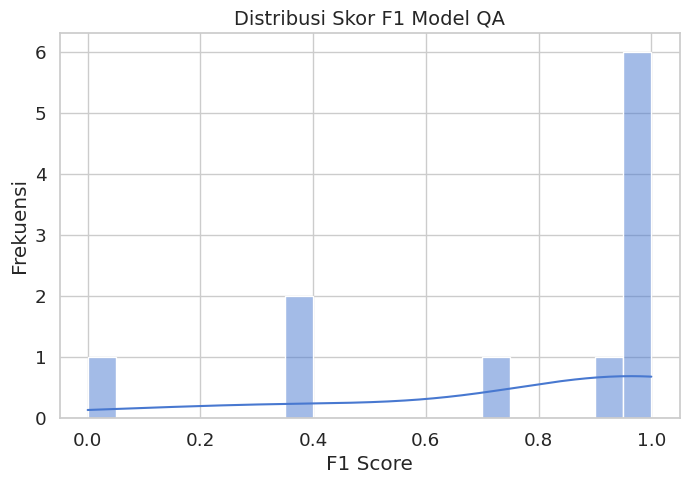

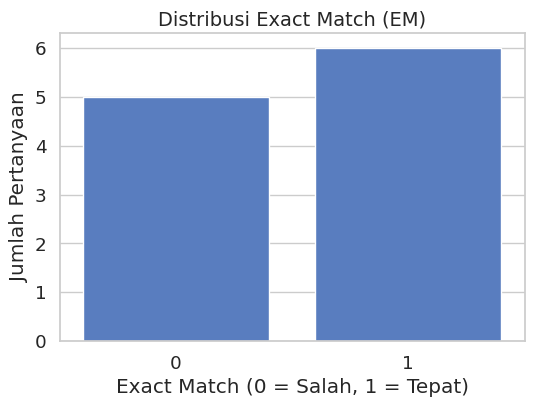

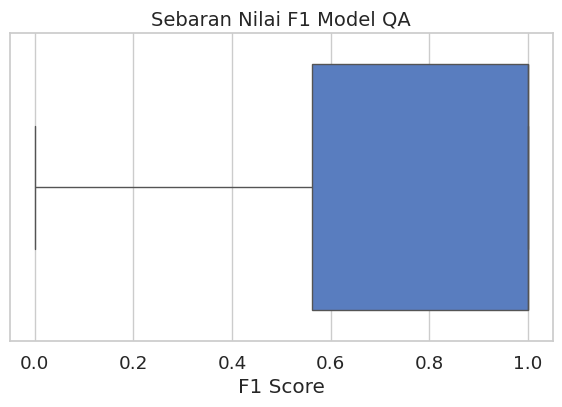


🔎 10 Pertanyaan dengan F1 Terendah:


,question,true,pred,F1
0,Apa yang menginspirasi Isaac Newton menemukan ...,apel jatuh dari pohon,gaya tarik antara \n dua benda bermassa.,0.000000
7,Bahasa Python digunakan dalam bidang?,"pengembangan web, analisis data, kecerdasan bu...",pengembangan web,0.363636
1,Apa tujuan awal Larry Page dan Sergey Brin saa...,menciptakan mesin pencari yang mampu mengindek...,menciptakan mesin pencari,0.375000
10,Apa salah satu dampak langsung dari peningkata...,Naiknya suhu bumi secara global.,naiknya suhu bumi,0.750000
3,Bagaimana Beyoncé pertama kali menjadi terkenal?,anggota grup musik Destiny's Child,anggota dari grup musik Destiny's Child,0.909091
2,Apa rumus kimia dari air?,H₂O,H₂O,1.000000
5,Siapa yang dianggap sebagai pelopor vaksin mod...,Edward Jenner,Edward Jenner,1.000000
4,Apa bentuk bumi berdasarkan bukti ilmiah modern?,bulat,bulat,1.000000
6,Apa salah satu bentuk serangan yang menggunaka...,phishing,phishing,1.000000
8,Tahun berapa didirikannya Tesla?,2003,2003,1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Pastikan df sudah ada, misalnya seperti ini:
# df = pd.DataFrame(results)

# Warna tema biar lebih rapi
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# 1️⃣ Distribusi skor F1
plt.figure(figsize=(8, 5))
sns.histplot(df["F1"], bins=20, kde=True)
plt.title("Distribusi Skor F1 Model QA", fontsize=14)
plt.xlabel("F1 Score")
plt.ylabel("Frekuensi")
plt.show()

# 2️⃣ Distribusi Exact Match (0 atau 1)
plt.figure(figsize=(6, 4))
sns.countplot(x="EM", data=df)
plt.title("Distribusi Exact Match (EM)", fontsize=14)
plt.xlabel("Exact Match (0 = Salah, 1 = Tepat)")
plt.ylabel("Jumlah Pertanyaan")
plt.show()

# 3️⃣ Scatter antara Confidence Score model vs F1 Score
if "score" in df.columns and df["score"].notnull().any():
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x="score", y="F1", data=df)
    plt.title("Korelasi Confidence Score dan F1", fontsize=14)
    plt.xlabel("Confidence Score dari Model")
    plt.ylabel("F1 Score")
    plt.show()

# 4️⃣ Boxplot F1 untuk melihat sebaran performa
plt.figure(figsize=(7, 4))
sns.boxplot(x=df["F1"])
plt.title("Sebaran Nilai F1 Model QA", fontsize=14)
plt.xlabel("F1 Score")
plt.show()

# 5️⃣ (Opsional) Top 10 pertanyaan dengan F1 terendah
worst_cases = df.sort_values("F1").head(10)
print("\n🔎 10 Pertanyaan dengan F1 Terendah:")
display(worst_cases[["question", "true", "pred", "F1"]])
